## Part 1: Metadata Retrieval and Analysis from PanKbase API

### A. Query Analysis Set and Extract Linked Measurement Sets

### Use case 2: Reference map of islet cell type-specific gene expression derived from single cell RNA-seq assays of 191 samples (140 donors) from HPAP;IIDP and Prodo.
https://data.pankbase.org/analysis-sets/PKBDS1349YHGQ/

### Configuration & Setup

In [1]:
# === USER CONFIGURATION VARIABLES ===
# Modify these values to customize your analysis
ANALYSIS_SET_ID <- "PKBDS1349YHGQ"     # Dataset ID to analyze
PLOT_THEME <- "minimal"                # Plot theme: minimal, bw, classic, void
COLOR_PALETTE <- "Set2"                # Color palette: Set1, Set2, Dark2, Pastel1
HISTOGRAM_BINS <- 15                   # Number of bins for histograms
PLOT_ALPHA <- 0.7                      # Transparency for plots (0-1)
PLOT_SIZE <- 3                         # Point size for scatter plots
SHOW_PROGRESS <- TRUE                  # Show progress messages during data loading
MAX_RETRIES <- 3                       # Max API retry attempts
TIMEOUT_SECONDS <- 30                  # API timeout in seconds

# === DEFAULTS (automatic fallbacks) ===
ANALYSIS_SET_ID <- ifelse(exists("ANALYSIS_SET_ID") && !is.null(ANALYSIS_SET_ID), ANALYSIS_SET_ID, "PKBDS1349YHGQ")
PLOT_THEME <- ifelse(exists("PLOT_THEME") && !is.null(PLOT_THEME), PLOT_THEME, "minimal")
COLOR_PALETTE <- ifelse(exists("COLOR_PALETTE") && !is.null(COLOR_PALETTE), COLOR_PALETTE, "Set2")
HISTOGRAM_BINS <- ifelse(exists("HISTOGRAM_BINS") && !is.null(HISTOGRAM_BINS), HISTOGRAM_BINS, 15)
PLOT_ALPHA <- ifelse(exists("PLOT_ALPHA") && !is.null(PLOT_ALPHA), PLOT_ALPHA, 0.7)
PLOT_SIZE <- ifelse(exists("PLOT_SIZE") && !is.null(PLOT_SIZE), PLOT_SIZE, 3)

cat("=== ANALYSIS CONFIGURATION ===\n")
cat("Dataset ID:", ANALYSIS_SET_ID, "\n")
cat("Plot theme:", PLOT_THEME, "\n")
cat("Color palette:", COLOR_PALETTE, "\n")
cat("Histogram bins:", HISTOGRAM_BINS, "\n")
cat("=====================================\n\n")

# Install and load required packages
required_packages <- c("httr", "jsonlite", "dplyr", "ggplot2", "readr", 
                      "RColorBrewer", "gridExtra", "knitr", "viridis")

missing_packages <- required_packages[!required_packages %in% installed.packages()[,"Package"]]
if(length(missing_packages) > 0) {
  cat("Installing missing packages:", paste(missing_packages, collapse = ", "), "\n")
  install.packages(missing_packages)
}

# Load libraries
suppressMessages({
  for(pkg in required_packages) {
    library(pkg, character.only = TRUE)
  }
})

# Set plot theme
plot_theme_func <- switch(PLOT_THEME,
  "minimal" = theme_minimal(),
  "bw" = theme_bw(), 
  "classic" = theme_classic(),
  "void" = theme_void(),
  theme_minimal()
)

theme_set(plot_theme_func)

cat("Libraries loaded and configuration set!\n")

=== ANALYSIS CONFIGURATION ===
Dataset ID: PKBDS1349YHGQ 
Plot theme: minimal 
Color palette: Set2 
Histogram bins: 15 

Libraries loaded and configuration set!


### API Setup & Helper Functions

In [2]:
# Base URLs and API configuration
base_url <- "https://api.data.pankbase.org"
analysis_set_id <- ANALYSIS_SET_ID
analysis_url <- paste0(base_url, "/analysis-sets/", analysis_set_id, "/")

# Function to safely query API
safe_api_query <- function(url) {
  tryCatch({
    response <- GET(url)
    if (status_code(response) == 200) {
      return(fromJSON(content(response, "text", encoding = "UTF-8")))
    } else {
      warning(paste("API request failed for:", url, "Status:", status_code(response)))
      return(NULL)
    }
  }, error = function(e) {
    warning(paste("Error querying:", url, "-", e$message))
    return(NULL)
  })
}

# Function to extract donor accession from sample data
extract_donor_accession <- function(sample_data) {
  if (!is.null(sample_data$donors) && length(sample_data$donors) > 0) {
    donor_url <- sample_data$donors[[1]]
    if (is.character(donor_url)) {
      return(basename(donor_url))
    } else if (is.list(donor_url) && "accession" %in% names(donor_url)) {
      return(donor_url$accession)
    }
  }
  return(NA)
}

# Function to safely extract values with default
safe_extract <- function(data, field, default = NA) {
  if (field %in% names(data) && !is.null(data[[field]])) {
    return(data[[field]])
  }
  return(default)
}

# Function to extract sample accessions properly
extract_sample_accessions <- function(samples_data) {
  sample_accessions <- c()
  
  if (is.list(samples_data)) {
    for (sample in samples_data) {
      if (is.list(sample)) {
        if ("accession" %in% names(sample)) {
          accession <- sample$accession
          if (is.character(accession) && length(accession) == 1) {
            if (grepl("^PKBSM", accession)) {
              sample_accessions <- c(sample_accessions, accession)
            }
          }
        }
      } else if (is.character(sample)) {
        accession <- basename(sample)
        if (grepl("^PKBSM", accession)) {
          sample_accessions <- c(sample_accessions, accession)
        }
      }
    }
  }
  
  return(unique(sample_accessions))
}

cat("API functions configured successfully!\n")

API functions configured successfully!


### Measurement Set Extraction

In [ ]:
# Query the analysis set
cat(" Querying analysis set:", analysis_url, "\n")
analysis_data <- safe_api_query(analysis_url)

if (!is.null(analysis_data)) {
  cat(" Successfully retrieved analysis set data\n")
  cat("Description:", analysis_data$description, "\n")
} else {
  stop(" Failed to retrieve analysis set data")
}

# Extract measurement sets associated with analysis set
cat("\n=== Extracting measurement sets ===\n")

# Debug: Show the structure around input_file_sets
if ("input_file_sets" %in% names(analysis_data)) {
  cat("Found input_file_sets field\n")
  if(SHOW_PROGRESS) {
    cat("Structure:\n")
    str(analysis_data$input_file_sets, max.level = 3)
  }
}

measurement_set_accessions <- c()

# Method 1: Extract from input_file_sets
if ("input_file_sets" %in% names(analysis_data) && is.list(analysis_data$input_file_sets)) {
  
  for (i in seq_along(analysis_data$input_file_sets)) {
    file_set <- analysis_data$input_file_sets[[i]]
    
    if(SHOW_PROGRESS) cat("Processing input file set", i, "\n")
    
    if (is.list(file_set)) {
      if(SHOW_PROGRESS) cat("  Type: list with names:", paste(names(file_set), collapse = ", "), "\n")
      
      # Direct accession field
      if ("accession" %in% names(file_set)) {
        accession <- file_set$accession
        if(SHOW_PROGRESS) cat("  Found accession:", accession, "\n")
        if (is.character(accession) && grepl("^PKBDS", accession)) {
          measurement_set_accessions <- c(measurement_set_accessions, accession)
        }
      }
      
      # Extract from @id field
      if ("@id" %in% names(file_set)) {
        id_path <- file_set$`@id`
        if(SHOW_PROGRESS) cat("  Found @id:", id_path, "\n")
        
        if (is.character(id_path) && grepl("/measurement-sets/", id_path)) {
          accession <- gsub(".*/measurement-sets/([^/]+)/?.*", "\\1", id_path)
          if(SHOW_PROGRESS) cat("  Extracted accession from @id:", accession, "\n")
          
          if (grepl("^PKBDS", accession)) {
            measurement_set_accessions <- c(measurement_set_accessions, accession)
          }
        }
      }
      
    } else if (is.character(file_set)) {
      if(SHOW_PROGRESS) cat("  Type: character -", file_set, "\n")
      if (grepl("/measurement-sets/", file_set)) {
        accession <- gsub(".*/measurement-sets/([^/]+)/?.*", "\\1", file_set)
        if (grepl("^PKBDS", accession)) {
          measurement_set_accessions <- c(measurement_set_accessions, accession)
        }
      } else if (grepl("^PKBDS", file_set)) {
        measurement_set_accessions <- c(measurement_set_accessions, file_set)
      }
    }
  }
}

# Remove duplicates
measurement_set_accessions <- unique(measurement_set_accessions)

cat("\n Extracted", length(measurement_set_accessions), "measurement set accessions\n")

if (length(measurement_set_accessions) > 0) {
  if(SHOW_PROGRESS) {
    cat("Accessions:\n")
    for (i in seq_along(measurement_set_accessions)) {
      cat("  ", i, ":", measurement_set_accessions[i], "\n")
    }
  }
} else {
  cat("Could not extract any measurement set accessions\n")
  stop("Cannot proceed without measurement set accessions")
}

### Load All Metadata (Measurement Sets, Samples, Donors)

In [4]:
# Initialize data storage
donor_data_list <- list()
sample_data_list <- list()
measurement_data_list <- list()

cat(" Starting metadata collection...\n")
cat("Initialized data storage for", length(measurement_set_accessions), "measurement sets\n")

start_time <- Sys.time()

# Query each measurement set individually
for (i in seq_along(measurement_set_accessions)) {
  ms_accession <- measurement_set_accessions[i]
  
  if(SHOW_PROGRESS) cat("\n Processing measurement set", i, ":", ms_accession, "\n")
  
  # Query measurement set
  ms_url <- paste0(base_url, "/measurement-sets/", ms_accession, "/")
  ms_data <- safe_api_query(ms_url)
  
  if (!is.null(ms_data)) {
    measurement_data_list[[ms_accession]] <- ms_data
    
    # Extract sample accessions from measurement set
    if (!is.null(ms_data$samples) && length(ms_data$samples) > 0) {
      sample_accessions <- extract_sample_accessions(ms_data$samples)
      
      if (length(sample_accessions) > 0) {
        if(SHOW_PROGRESS) cat("  ├─ Found", length(sample_accessions), "samples\n")
        
        # Query each sample
        for (sample_accession in sample_accessions) {
          if (!sample_accession %in% names(sample_data_list)) {
            
            # Query sample data
            sample_url <- paste0(base_url, "/primary-islet/", sample_accession, "/")
            sample_data <- safe_api_query(sample_url)
            
            if (!is.null(sample_data)) {
              sample_data_list[[sample_accession]] <- sample_data
              
              # Extract and query donor
              donor_accession <- extract_donor_accession(sample_data)
              if (!is.na(donor_accession) && !donor_accession %in% names(donor_data_list)) {
                donor_url <- paste0(base_url, "/human-donors/", donor_accession, "/")
                donor_data <- safe_api_query(donor_url)
                
                if (!is.null(donor_data)) {
                  donor_data_list[[donor_accession]] <- donor_data
                  if(SHOW_PROGRESS) cat("    └─ Sample", sample_accession, "→ Donor", donor_accession, "\n")
                }
              }
            }
          }
        }
      } else {
        if(SHOW_PROGRESS) cat("  ├─ No valid sample accessions found\n")
      }
    }
  } else {
    cat(" Failed to query MS", ms_accession, "\n")
  }
  
  # Progress indicator
  if (i %% 5 == 0) {
    elapsed <- as.numeric(difftime(Sys.time(), start_time, units = "secs"))
    cat("\n Progress:", round(100 * i/length(measurement_set_accessions), 1), "% complete\n")
    cat("   Elapsed time:", round(elapsed, 1), "seconds\n")
    cat("   Current totals:", length(donor_data_list), "donors,", length(sample_data_list), "samples\n")
  }
}

end_time <- Sys.time()
total_time <- as.numeric(difftime(end_time, start_time, units = "secs"))

cat("\n DATA COLLECTION COMPLETE!\n")
cat(" Final counts:\n")
cat("   • Donors:", length(donor_data_list), "\n")
cat("   • Samples:", length(sample_data_list), "\n")
cat("   • Measurement sets:", length(measurement_data_list), "\n")
cat("  Total collection time:", round(total_time, 1), "seconds\n")

 Starting metadata collection...
Initialized data storage for 191 measurement sets

 Processing measurement set 1 : PKBDS7517ETIH 
  ├─ Found 1 samples
    └─ Sample PKBSM3978TTUM → Donor PKBDO3282JIMC 

 Processing measurement set 2 : PKBDS3115TIIM 
  ├─ Found 1 samples
    └─ Sample PKBSM3998VGXS → Donor PKBDO6015OXWK 

 Processing measurement set 3 : PKBDS6838ZEOQ 
  ├─ Found 1 samples
    └─ Sample PKBSM5236BEXP → Donor PKBDO7633ARWR 

 Processing measurement set 4 : PKBDS8372CZUB 
  ├─ Found 1 samples
    └─ Sample PKBSM4126RWLD → Donor PKBDO2364QVNX 

 Processing measurement set 5 : PKBDS0336QCMR 
  ├─ Found 1 samples
    └─ Sample PKBSM5695NHYL → Donor PKBDO9514HUCG 

 Progress: 2.6 % complete
   Elapsed time: 1.7 seconds
   Current totals: 5 donors, 5 samples

 Processing measurement set 6 : PKBDS0215JABB 
  ├─ Found 1 samples
    └─ Sample PKBSM1058XSQO → Donor PKBDO5844WPGY 

 Processing measurement set 7 : PKBDS1245LFAS 
  ├─ Found 1 samples
    └─ Sample PKBSM4901JGKH → Don


 DATA COLLECTION COMPLETE!
 Final counts:
   • Donors: 140 
   • Samples: 179 
   • Measurement sets: 191 
  Total collection time: 37.9 seconds


### Process Donor Metadata

In [5]:
# Extract donor metadata
cat("Processing donor metadata...\n")

donor_metadata <- data.frame(
  donor_accession = names(donor_data_list),
  stringsAsFactors = FALSE
)

# Extract all donor fields
for (i in seq_along(donor_data_list)) {
  donor <- donor_data_list[[i]]
  
  donor_metadata$age[i] <- safe_extract(donor, "age")
  donor_metadata$bmi[i] <- safe_extract(donor, "bmi")
  donor_metadata$sex[i] <- safe_extract(donor, "sex")
  donor_metadata$hba1c[i] <- safe_extract(donor, "hba1c")
  donor_metadata$diabetes_status_description[i] <- safe_extract(donor, "diabetes_status_description")
  donor_metadata$ethnicity[i] <- ifelse(!is.null(donor$ethnicities) && length(donor$ethnicities) > 0, 
                                       donor$ethnicities[1], NA)
  donor_metadata$cause_of_death[i] <- safe_extract(donor, "cause_of_death")
  donor_metadata$c_peptide[i] <- safe_extract(donor, "c_peptide")
}

# Convert numeric columns
numeric_cols <- c("age", "bmi", "hba1c", "c_peptide")
donor_metadata[numeric_cols] <- lapply(donor_metadata[numeric_cols], as.numeric)

# Display summary
cat("Donor Metadata Summary:\n")
str(donor_metadata)
print(summary(donor_metadata))

cat("Donor metadata processing complete!\n")

Processing donor metadata...
Donor Metadata Summary:
'data.frame':	140 obs. of  9 variables:
 $ donor_accession            : chr  "PKBDO3282JIMC" "PKBDO6015OXWK" "PKBDO7633ARWR" "PKBDO2364QVNX" ...
 $ age                        : num  22 14 13 39 17 18 24 4 23 10 ...
 $ bmi                        : num  29.8 13.2 21.4 34.7 21.4 ...
 $ sex                        : chr  "male" "male" "female" "female" ...
 $ hba1c                      : num  5.2 NA NA 4.7 8.9 5.5 4.9 9.8 5.3 9 ...
 $ diabetes_status_description: chr  "control without diabetes" "type 1 diabetes" "type 1 diabetes" "control without diabetes" ...
 $ ethnicity                  : chr  "White" "Caucasian" "Caucasian" "Caucasian" ...
 $ cause_of_death             : chr  "Head trauma" "Anoxia" "Anoxia" "Anoxia" ...
 $ c_peptide                  : num  8.82 0.37 0.02 9.35 0.02 5.6 0.25 0.3 3.83 0.02 ...
 donor_accession         age             bmi            sex           
 Length:140         Min.   : 1.00   Min.   :12.00   Length

### Donor Demographics

Creating donor demographic visualizations...


Warning message:
“Removed 4 rows containing non-finite outside the scale range (`stat_bin()`).”


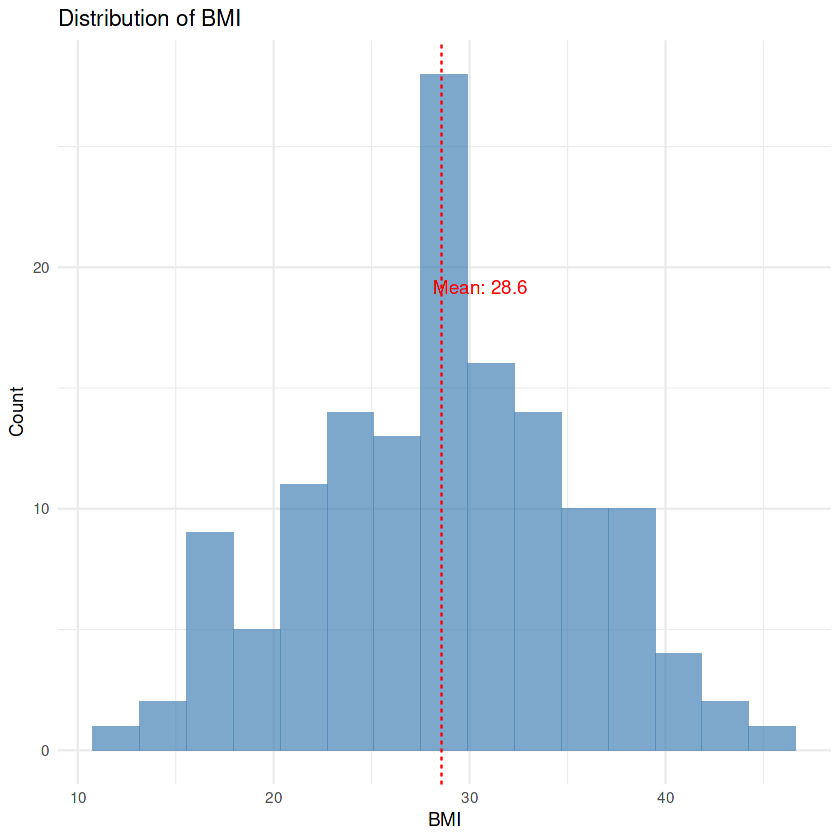

 Basic donor histograms displayed!


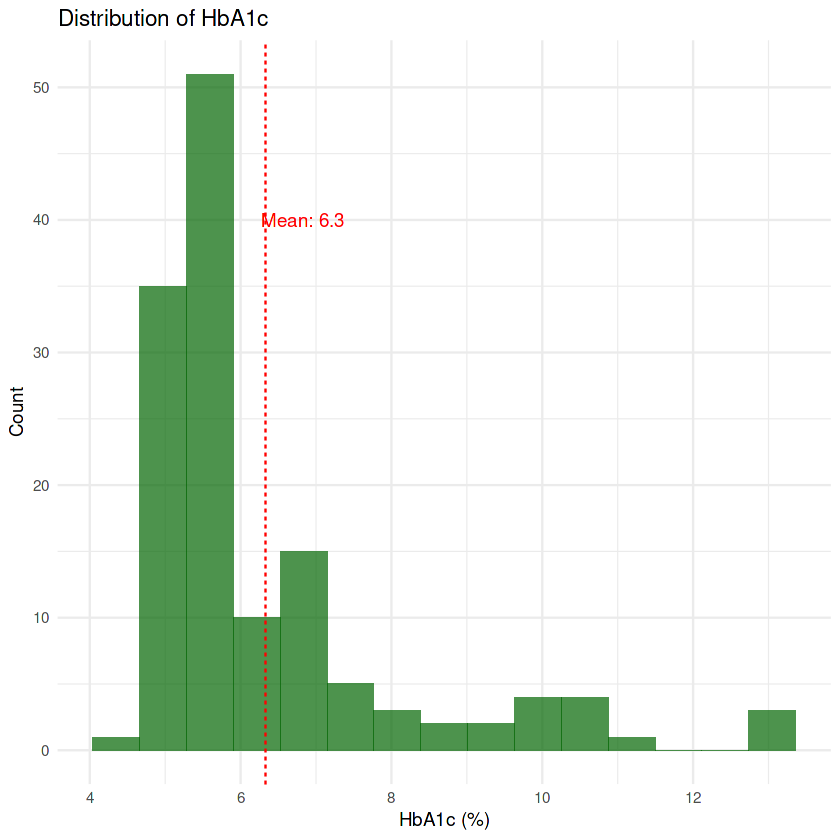

In [6]:
# Create basic donor demographic histograms
cat("Creating donor demographic visualizations...\n")

# BMI histogram
p1 <- ggplot(donor_metadata, aes(x = bmi)) +
  geom_histogram(bins = HISTOGRAM_BINS, fill = "steelblue", alpha = PLOT_ALPHA) +
  labs(title = "Distribution of BMI", x = "BMI", y = "Count") +
  geom_vline(aes(xintercept = mean(bmi, na.rm = TRUE)), color = "red", linetype = "dashed") +
  annotate("text", x = mean(donor_metadata$bmi, na.rm = TRUE) + 2, 
           y = max(table(cut(donor_metadata$bmi, HISTOGRAM_BINS))) * 0.8,
           label = paste("Mean:", round(mean(donor_metadata$bmi, na.rm = TRUE), 1)), color = "red")

print(p1)

# HbA1c histogram
p2 <- ggplot(donor_metadata, aes(x = hba1c)) +
  geom_histogram(bins = HISTOGRAM_BINS, fill = "darkgreen", alpha = PLOT_ALPHA) +
  labs(title = "Distribution of HbA1c", x = "HbA1c (%)", y = "Count") +
  geom_vline(aes(xintercept = mean(hba1c, na.rm = TRUE)), color = "red", linetype = "dashed") +
  annotate("text", x = mean(donor_metadata$hba1c, na.rm = TRUE) + 0.5, 
           y = max(table(cut(donor_metadata$hba1c, HISTOGRAM_BINS))) * 0.8,
           label = paste("Mean:", round(mean(donor_metadata$hba1c, na.rm = TRUE), 1)), color = "red")

print(p2)

cat(" Basic donor histograms displayed!\n")

### Donor Demographics - Categorical Data

Creating categorical demographic plots...


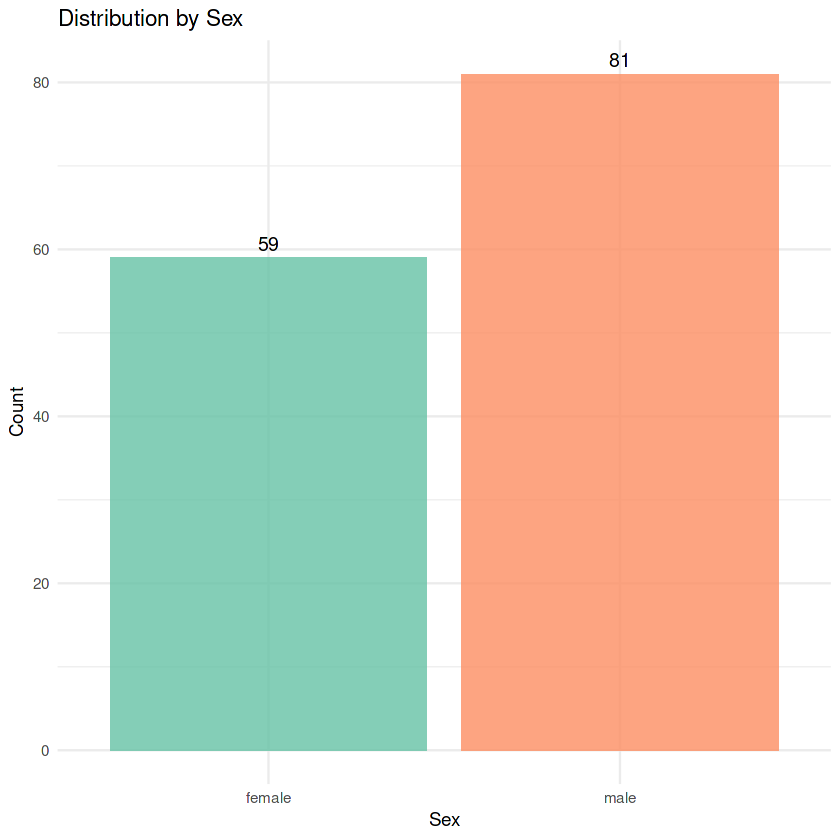

Categorical demographic plots displayed!


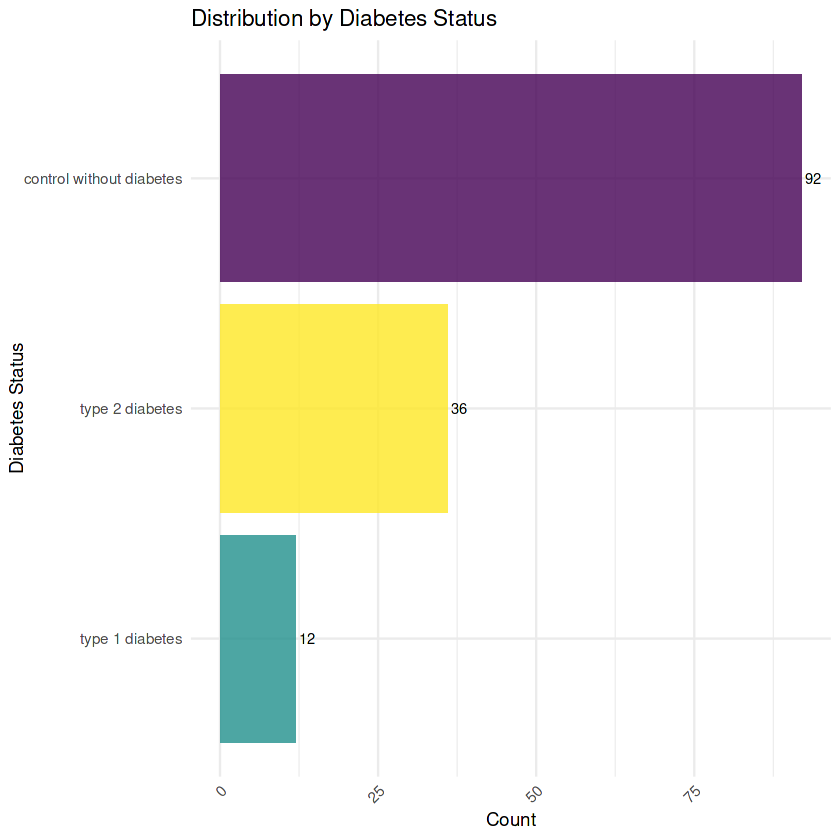

In [7]:
# Create categorical demographic visualizations
cat("Creating categorical demographic plots...\n")

# Sex barplot
sex_counts <- table(donor_metadata$sex)
p3 <- ggplot(data.frame(sex = names(sex_counts), count = as.numeric(sex_counts)), 
             aes(x = sex, y = count, fill = sex)) +
  geom_bar(stat = "identity", alpha = 0.8) +
  geom_text(aes(label = count), vjust = -0.5, size = 4) +
  labs(title = "Distribution by Sex", x = "Sex", y = "Count") +
  scale_fill_brewer(type = "qual", palette = COLOR_PALETTE) +
  theme(legend.position = "none")

print(p3)

# Diabetes status barplot
diabetes_counts <- table(donor_metadata$diabetes_status_description, useNA = "ifany")
p4 <- ggplot(data.frame(status = names(diabetes_counts), count = as.numeric(diabetes_counts)), 
             aes(x = reorder(status, count), y = count, fill = status)) +
  geom_bar(stat = "identity", alpha = 0.8) +
  geom_text(aes(label = count), hjust = -0.2, size = 3) +
  labs(title = "Distribution by Diabetes Status", x = "Diabetes Status", y = "Count") +
  scale_fill_viridis_d() +
  theme(legend.position = "none", axis.text.x = element_text(angle = 45, hjust = 1)) +
  coord_flip()

print(p4)

cat("Categorical demographic plots displayed!\n")

### Combined Donor Demographics Plot

Creating combined donor demographics plot...


Warning message:
“Removed 4 rows containing non-finite outside the scale range (`stat_bin()`).”


Combined donor demographics plot displayed!


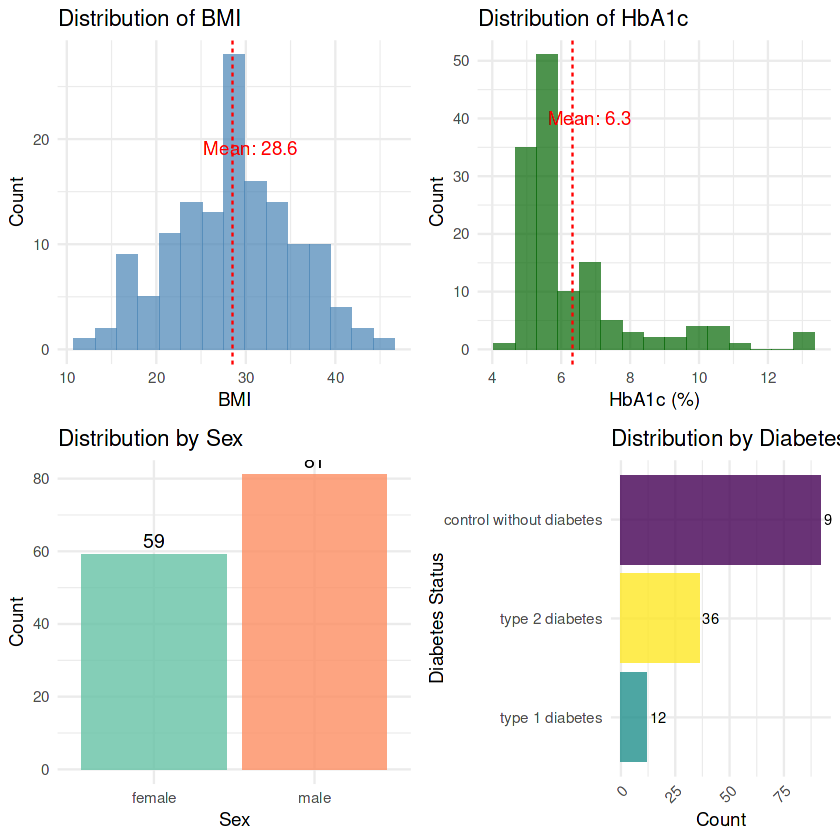

In [8]:
# Create combined demographics plot
cat("Creating combined donor demographics plot...\n")

# Combine the four main plots
grid.arrange(p1, p2, p3, p4, ncol = 2)

cat("Combined donor demographics plot displayed!\n")

### Donor Correlation Analysis

Performing correlation analysis...


`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 4 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`).”


Correlation between BMI and HbA1c: -0.108 (p-value: 0.2127 )
Age vs C-peptide correlation: 0.132 (p-value: 0.2516 )
Correlation analysis complete!


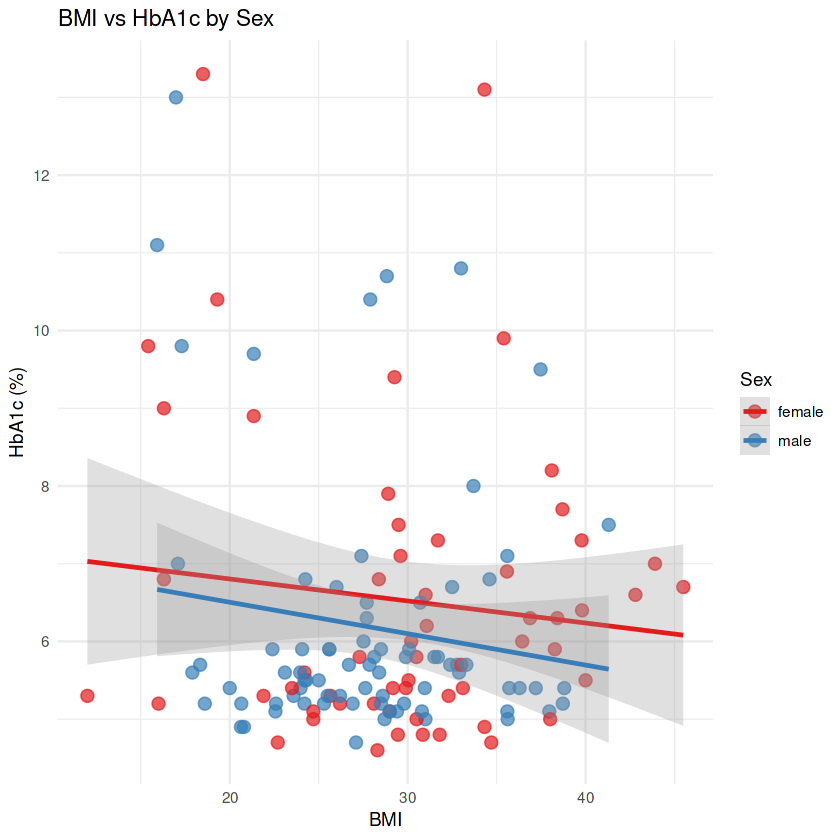

In [9]:
# BMI vs HbA1c correlation analysis
cat("Performing correlation analysis...\n")

# BMI vs HbA1c scatter plot
p5 <- ggplot(donor_metadata, aes(x = bmi, y = hba1c, color = sex)) +
  geom_point(size = PLOT_SIZE, alpha = PLOT_ALPHA) +
  geom_smooth(method = "lm", se = TRUE, alpha = 0.3) +
  labs(title = "BMI vs HbA1c by Sex", 
       x = "BMI", y = "HbA1c (%)", color = "Sex") +
  scale_color_brewer(type = "qual", palette = "Set1")

print(p5)

# Calculate correlation
cor_result <- cor.test(donor_metadata$bmi, donor_metadata$hba1c, use = "complete.obs")
cat("Correlation between BMI and HbA1c:", round(cor_result$estimate, 3), 
    "(p-value:", round(cor_result$p.value, 4), ")\n")

# Additional correlations if data available
if(sum(!is.na(donor_metadata$age) & !is.na(donor_metadata$c_peptide)) > 3) {
  cor_age_cpep <- cor.test(donor_metadata$age, donor_metadata$c_peptide, use = "complete.obs")
  cat("Age vs C-peptide correlation:", round(cor_age_cpep$estimate, 3), 
      "(p-value:", round(cor_age_cpep$p.value, 4), ")\n")
}

cat("Correlation analysis complete!\n")

### Process Sample Metadata

In [11]:
# Extract sample metadata
cat("Processing sample metadata...\n")

sample_metadata <- data.frame(
  sample_accession = names(sample_data_list),
  stringsAsFactors = FALSE
)

# Extract all sample fields
for (i in seq_along(sample_data_list)) {
  sample <- sample_data_list[[i]]
  
  sample_metadata$isolation_center[i] <- safe_extract(sample, "isolation_center")
  sample_metadata$islet_yield[i] <- safe_extract(sample, "islet_yield")
  sample_metadata$prep_viability[i] <- safe_extract(sample, "prep_viability")
  sample_metadata$pancreas_weight[i] <- safe_extract(sample, "pancreas_weight")
  sample_metadata$cold_ischaemia_time[i] <- safe_extract(sample, "cold_ischaemia_time")
  sample_metadata$warm_ischaemia_duration[i] <- safe_extract(sample, "warm_ischaemia_duration")
  
  # Extract donor accession for linking
  sample_metadata$donor_accession[i] <- extract_donor_accession(sample)
}

# Convert numeric columns
numeric_cols <- c("islet_yield", "prep_viability", "pancreas_weight", 
                 "cold_ischaemia_time", "warm_ischaemia_duration")
sample_metadata[numeric_cols] <- lapply(sample_metadata[numeric_cols], as.numeric)

cat("Sample Metadata Summary:\n")
str(sample_metadata)
print(summary(sample_metadata))

cat("Sample metadata processing complete!\n")

Processing sample metadata...
Sample Metadata Summary:
'data.frame':	179 obs. of  8 variables:
 $ sample_accession       : chr  "PKBSM3978TTUM" "PKBSM3998VGXS" "PKBSM5236BEXP" "PKBSM4126RWLD" ...
 $ isolation_center       : chr  "University of Pennsylvania (Upenn)" "University of Pennsylvania (Upenn)" "University of Pennsylvania (Upenn)" "University of Pennsylvania (Upenn)" ...
 $ islet_yield            : num  260000 40260 30658 636852 26296 ...
 $ prep_viability         : num  92 92 93 94 95 93 92 88 96 88 ...
 $ pancreas_weight        : num  2681 1729 1232 7410 996 ...
 $ cold_ischaemia_time    : num  12.13 13.2 16.82 8.55 21.05 ...
 $ warm_ischaemia_duration: num  NA NA NA NA 0.35 ...
 $ donor_accession        : chr  "PKBDO3282JIMC" "PKBDO6015OXWK" "PKBDO7633ARWR" "PKBDO2364QVNX" ...
 sample_accession   isolation_center    islet_yield     prep_viability 
 Length:179         Length:179         Min.   : 20585   Min.   :80.00  
 Class :character   Class :character   1st Qu.:104771   1s

### Sample Quality Visualizations

Creating sample quality visualizations...


Warning message:
“Removed 99 rows containing non-finite outside the scale range (`stat_bin()`).”


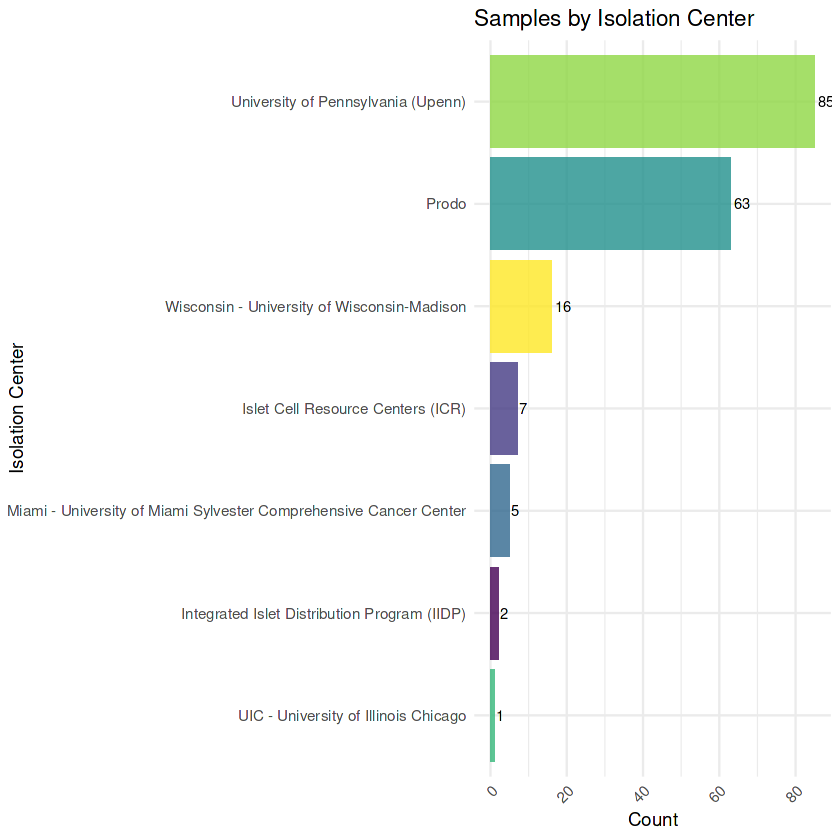

Warning message:
“Removed 99 rows containing non-finite outside the scale range (`stat_bin()`).”


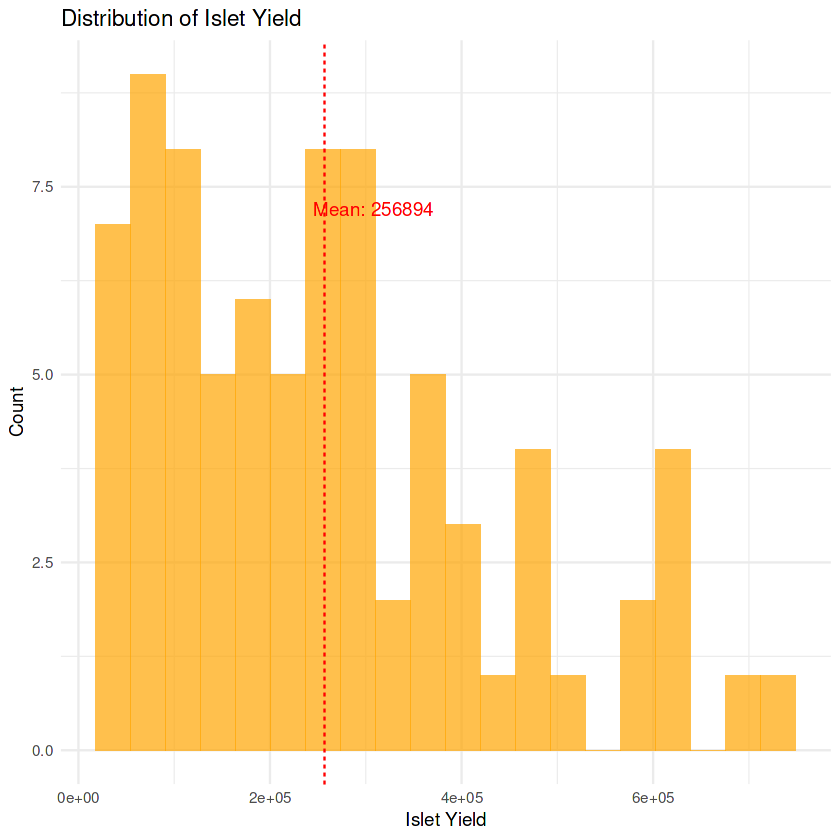

Sample quality plots displayed!


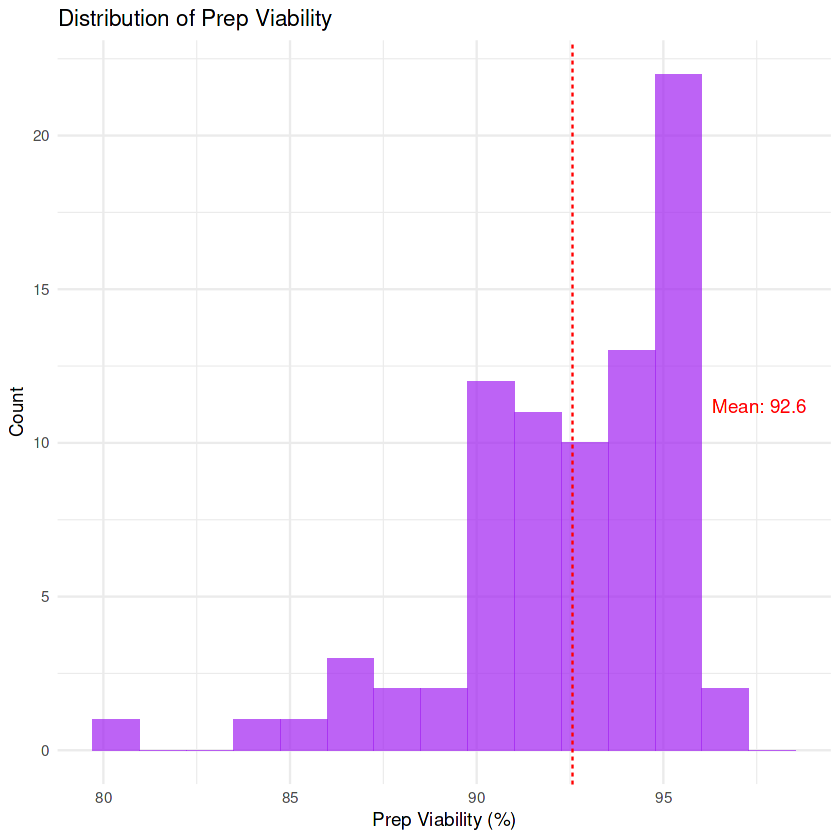

In [12]:
# Create sample quality visualizations
cat("Creating sample quality visualizations...\n")

# Isolation center barplot
center_counts <- table(sample_metadata$isolation_center, useNA = "ifany")
p6 <- ggplot(data.frame(center = names(center_counts), count = as.numeric(center_counts)), 
             aes(x = reorder(center, count), y = count, fill = center)) +
  geom_bar(stat = "identity", alpha = 0.8) +
  geom_text(aes(label = count), hjust = -0.2, size = 3) +
  labs(title = "Samples by Isolation Center", x = "Isolation Center", y = "Count") +
  scale_fill_viridis_d() +
  theme(legend.position = "none", axis.text.x = element_text(angle = 45, hjust = 1)) +
  coord_flip()

print(p6)

# Islet yield histogram
p7 <- ggplot(sample_metadata, aes(x = islet_yield)) +
  geom_histogram(bins = 20, fill = "orange", alpha = PLOT_ALPHA) +
  labs(title = "Distribution of Islet Yield", x = "Islet Yield", y = "Count") +
  geom_vline(aes(xintercept = mean(islet_yield, na.rm = TRUE)), color = "red", linetype = "dashed") +
  annotate("text", x = mean(sample_metadata$islet_yield, na.rm = TRUE) * 1.2, 
           y = max(table(cut(sample_metadata$islet_yield, 20)), na.rm = TRUE) * 0.8,
           label = paste("Mean:", round(mean(sample_metadata$islet_yield, na.rm = TRUE), 0)), color = "red")

print(p7)

# Prep viability histogram
p8 <- ggplot(sample_metadata, aes(x = prep_viability)) +
  geom_histogram(bins = HISTOGRAM_BINS, fill = "purple", alpha = PLOT_ALPHA) +
  labs(title = "Distribution of Prep Viability", x = "Prep Viability (%)", y = "Count") +
  geom_vline(aes(xintercept = mean(prep_viability, na.rm = TRUE)), color = "red", linetype = "dashed") +
  annotate("text", x = mean(sample_metadata$prep_viability, na.rm = TRUE) + 5, 
           y = max(table(cut(sample_metadata$prep_viability, HISTOGRAM_BINS)), na.rm = TRUE) * 0.8,
           label = paste("Mean:", round(mean(sample_metadata$prep_viability, na.rm = TRUE), 1)), color = "red")

print(p8)

cat("Sample quality plots displayed!\n")

### Sample viability and technical metrics

Cold ischemia time distribution displayed
Sample Quality Summary:
Islet Yield: Mean = 256894 , SD = 179765 
Prep Viability: Mean = 92.6 % , SD = 3.1 %
Sample technical metrics displayed!


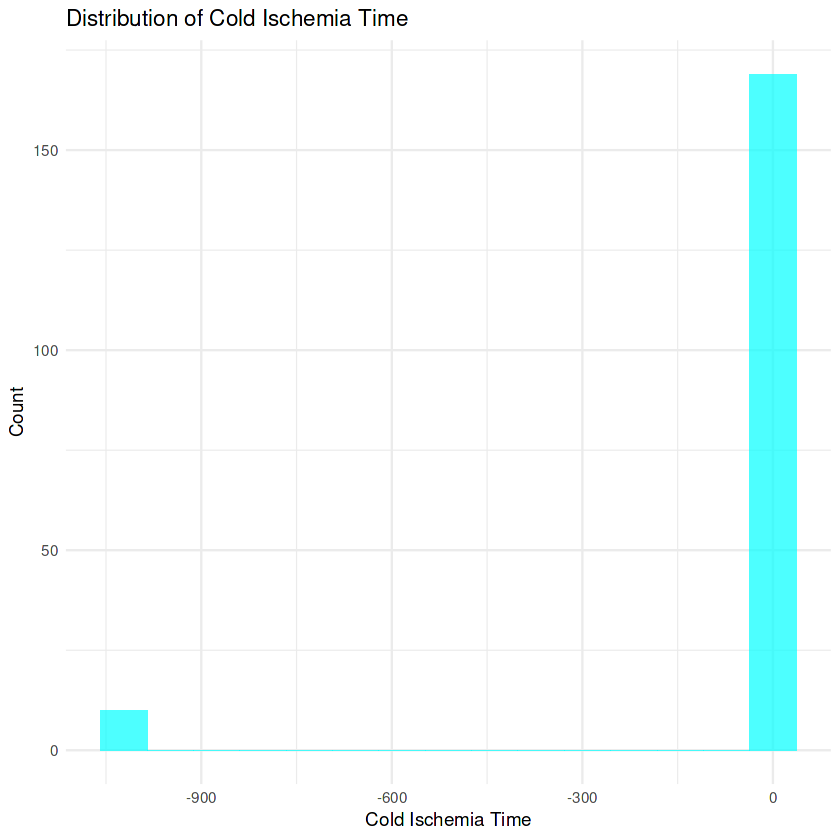

In [13]:
# Cold ischemia time if available
if(sum(!is.na(sample_metadata$cold_ischaemia_time)) > 5) {
  p9 <- ggplot(sample_metadata, aes(x = cold_ischaemia_time)) +
    geom_histogram(bins = HISTOGRAM_BINS, fill = "cyan", alpha = PLOT_ALPHA) +
    labs(title = "Distribution of Cold Ischemia Time", x = "Cold Ischemia Time", y = "Count")
  
  print(p9)
  cat("Cold ischemia time distribution displayed\n")
}

# Sample quality summary statistics
cat("Sample Quality Summary:\n")
cat("Islet Yield: Mean =", round(mean(sample_metadata$islet_yield, na.rm = TRUE), 0), 
    ", SD =", round(sd(sample_metadata$islet_yield, na.rm = TRUE), 0), "\n")
cat("Prep Viability: Mean =", round(mean(sample_metadata$prep_viability, na.rm = TRUE), 1), "%", 
    ", SD =", round(sd(sample_metadata$prep_viability, na.rm = TRUE), 1), "%\n")

cat("Sample technical metrics displayed!\n")

### Final Summary & Data Export

In [17]:
# Create comprehensive summary
cat(" FINAL ANALYSIS SUMMARY\n")
cat("=" , rep("=", 40), "\n")

# Dataset summary
summary_table <- data.frame(
  Metric = c("Analysis Set ID", "Total Measurement Sets", "Total Samples", "Total Donors", 
             "Avg Samples per Donor", "Male Donors", "Female Donors", "Diabetic Donors"),
  Value = c(ANALYSIS_SET_ID,
           length(measurement_data_list),
           nrow(sample_metadata), 
           nrow(donor_metadata),
           round(nrow(sample_metadata) / nrow(donor_metadata), 2),
           sum(donor_metadata$sex == "male", na.rm = TRUE),
           sum(donor_metadata$sex == "female", na.rm = TRUE),
           sum(grepl("diabetes", donor_metadata$diabetes_status_description, ignore.case = TRUE), na.rm = TRUE)),
  stringsAsFactors = FALSE
)

print(knitr::kable(summary_table, caption = "Dataset Summary"))

# Key findings summary
cat("\n KEY FINDINGS:\n")
cat("• Age range:", round(min(donor_metadata$age, na.rm = TRUE), 1), "-", 
    round(max(donor_metadata$age, na.rm = TRUE), 1), "years\n")
cat("• BMI range:", round(min(donor_metadata$bmi, na.rm = TRUE), 1), "-", 
    round(max(donor_metadata$bmi, na.rm = TRUE), 1), "\n")
cat("• Viability range:", round(min(sample_metadata$prep_viability, na.rm = TRUE), 1), "-", 
    round(max(sample_metadata$prep_viability, na.rm = TRUE), 1), "%\n")

# Data completeness
cat("\n DATA COMPLETENESS:\n")
completeness <- data.frame(
  Field = c("Age", "BMI", "Sex", "HbA1c", "Islet Yield", "Prep Viability"),
  Complete_Percent = c(
    round(100 * sum(!is.na(donor_metadata$age)) / nrow(donor_metadata), 1),
    round(100 * sum(!is.na(donor_metadata$bmi)) / nrow(donor_metadata), 1),
    round(100 * sum(!is.na(donor_metadata$sex)) / nrow(donor_metadata), 1),
    round(100 * sum(!is.na(donor_metadata$hba1c)) / nrow(donor_metadata), 1),
    round(100 * sum(!is.na(sample_metadata$islet_yield)) / nrow(sample_metadata), 1),
    round(100 * sum(!is.na(sample_metadata$prep_viability)) / nrow(sample_metadata), 1)
  )
)
print(completeness)

# Analysis configuration used
cat("\n ANALYSIS CONFIGURATION USED:\n")
cat("• Plot theme:", PLOT_THEME, "\n")
cat("• Color palette:", COLOR_PALETTE, "\n")
cat("• Histogram bins:", HISTOGRAM_BINS, "\n")

cat("\n ANALYSIS COMPLETE!\n")
cat(" Generated visualizations:\n")
cat("• Donor demographics (age, BMI, sex, diabetes status)\n")
cat("• Sample quality metrics (yield, viability, centers)\n")
cat("• Summary statistics and data completeness\n")

cat("\n Available data objects:\n")
cat("• donor_metadata - Donor demographic data\n")
cat("• sample_metadata - Sample quality and processing data\n")
cat("• measurement_data_list - Raw measurement set data\n")

end_time <- Sys.time()
total_analysis_time <- as.numeric(difftime(end_time, start_time, units = "mins"))
cat("\n  Total analysis time:", round(total_analysis_time, 2), "minutes\n")

 FINAL ANALYSIS SUMMARY
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


Table: Dataset Summary

|Metric                 |Value         |
|:----------------------|:-------------|
|Analysis Set ID        |PKBDS1349YHGQ |
|Total Measurement Sets |191           |
|Total Samples          |179           |
|Total Donors           |140           |
|Avg Samples per Donor  |1.28          |
|Male Donors            |81            |
|Female Donors          |59            |
|Diabetic Donors        |140           |

 KEY FINDINGS:
• Age range: 1 - 66 years
• BMI range: 12 - 45.5 
• Viability range: 80 - 97 %

 DATA COMPLETENESS:
           Field Complete_Percent
1            Age            100.0
2            BMI            100.0
3            Sex            100.0
4          HbA1c             97.1
5    Islet Yield             44.7
6 Prep Viability             44.7

 ANALYSIS CONFIGURATION USED:
• Plot theme: minimal 
• Color palette: Set2 
• Histogram bins: 15 

 AN

## Option 1
### READ RDS object and make plots using simple URL connection (most reliable for open access) no local download needed

File: https://data.pankbase.org/matrix-files/PKBFI5903OGWY

https://pankbase-data-v1.s3.us-west-2.amazonaws.com/analysis_resources/single_cell_objects/060425_scRNA_v3.3.rds

- No local storage required - Saves disk space (important for a ~10GB file)
- Faster start - No download wait time
- Memory efficient - File is streamed directly into R's memory
- Always current - You're always accessing the latest version

#### Important Considerations:

- Memory Requirements - The file will still consume ~10GB of RAM when loaded
- Network Stability - Streaming large files requires a stable internet connection
- Timeout Settings - Large files need extended timeout periods
- Error Handling - Network issues can interrupt the process

In [12]:
rds_url <- "https://pankbase-data-v1.s3.us-west-2.amazonaws.com/analysis_resources/single_cell_objects/060425_scRNA_v3.3.rds"
seurat_obj <- NULL

if (is.null(seurat_obj)) {
  cat("Trying direct URL connection with extended timeout...\n")
  
  # Set longer timeout (1 hour = 3600 seconds)
  options(timeout = 3600)
  
  loading_time <- system.time({
    tryCatch({
      seurat_obj <- readRDS(url(rds_url, open = "rb"))
      cat("✓ Success with direct URL method!\n")
    }, error = function(e) {
      cat("✗ Direct URL failed:", e$message, "\n")
    })
  })
  
  if (!is.null(seurat_obj)) {
    cat("Loading time:", loading_time["elapsed"], "seconds\n")
    cat("Loading time:", round(loading_time["elapsed"]/60, 1), "minutes\n")
  }
}

Trying direct URL connection with extended timeout...
✓ Success with direct URL method!
Loading time: 670.395 seconds
Loading time: 11.2 minutes


In [ ]:
if (exists("seurat_obj") && !is.null(seurat_obj)) {
  cat("=== SEURAT OBJECT ANALYSIS ===\n")
  
  # Check available reductions
  cat("Available dimensional reductions:\n")
  print(names(seurat_obj@reductions))
  
  # Check metadata columns
  cat("\nMetadata columns:\n")
  print(colnames(seurat_obj@meta.data))
  
  # Display first few rows of metadata
  cat("\nFirst few rows of cell metadata:\n")
  print(head(seurat_obj@meta.data))
  
  # Check if UMAP coordinates exist
  if ("umap" %in% names(seurat_obj@reductions)) {
    cat("\nUMAP coordinates are available!\n")
    umap_coords <- Embeddings(seurat_obj, reduction = "umap")
    cat("UMAP dimensions:", dim(umap_coords), "\n")
  } else {
    cat("\nUMAP coordinates not found. Available reductions:", names(seurat_obj@reductions), "\n")
  }
  
} else {
  cat("Seurat object not available for analysis.\n")
}

In [15]:
seurat_obj

An object of class Seurat 
19546 features across 448935 samples within 1 assay 
Active assay: RNA (19546 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 3 dimensional reductions calculated: pca, umap, harmony

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



Found cell type information in: Cell_Type 


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



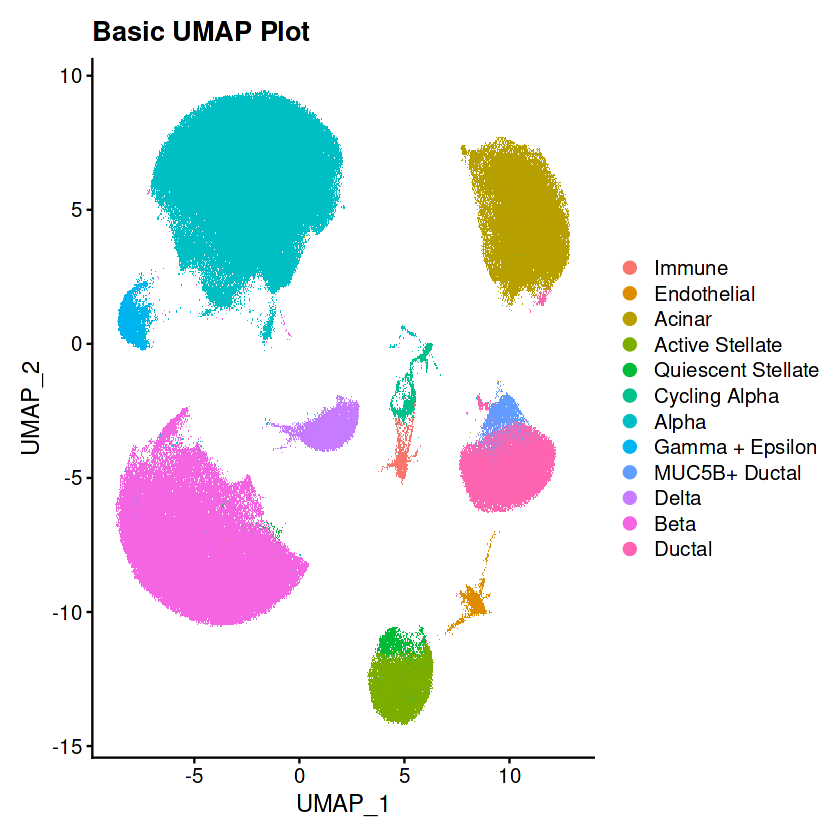

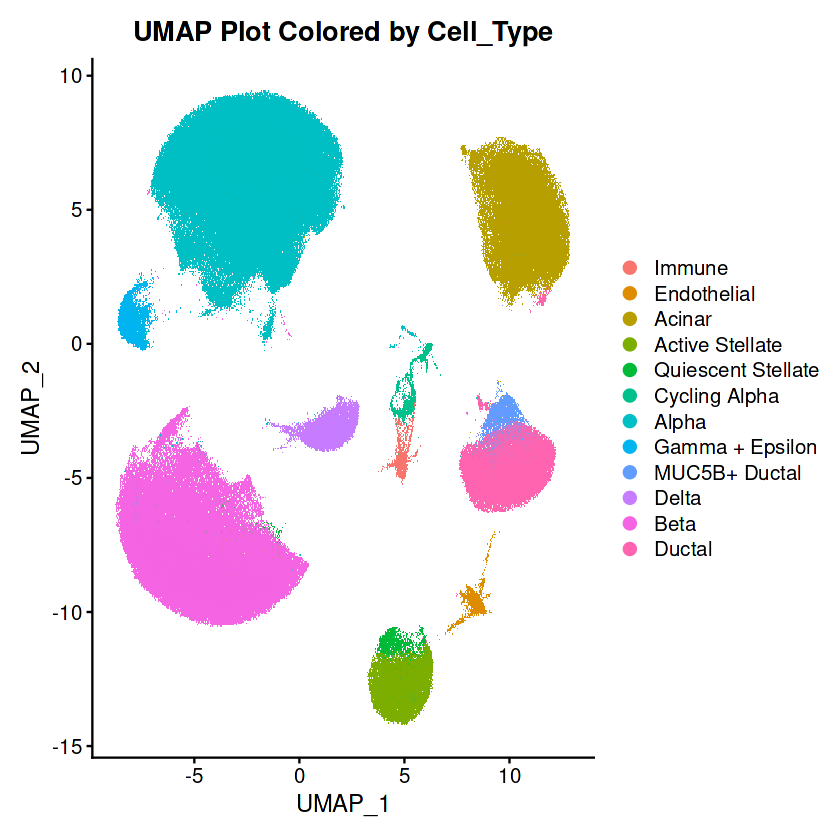

In [17]:
if (exists("seurat_obj") && !is.null(seurat_obj)) {
  
  # Check for UMAP or other reductions
  if ("umap" %in% names(seurat_obj@reductions)) {
    reduction_to_use <- "umap"
  } else if ("tsne" %in% names(seurat_obj@reductions)) {
    reduction_to_use <- "tsne"
    cat("UMAP not available, using t-SNE instead.\n")
  } else if (length(names(seurat_obj@reductions)) > 0) {
    reduction_to_use <- names(seurat_obj@reductions)[1]
    cat("Using first available reduction:", reduction_to_use, "\n")
  } else {
    cat("No dimensional reductions available in the object.\n")
    reduction_to_use <- NULL
  }
  
  if (!is.null(reduction_to_use)) {
    # Basic UMAP/reduction plot
    p_basic <- DimPlot(seurat_obj, reduction = reduction_to_use) +
      ggtitle(paste("Basic", toupper(reduction_to_use), "Plot"))
    print(p_basic)
    
    # Check for clustering information
    cluster_cols <- grep("cluster|seurat_clusters", colnames(seurat_obj@meta.data), 
                        value = TRUE, ignore.case = TRUE)
    
    if (length(cluster_cols) > 0) {
      cat("Found cluster information in:", cluster_cols[1], "\n")
      p_cluster <- DimPlot(seurat_obj, reduction = reduction_to_use, 
                          group.by = cluster_cols[1]) +
        ggtitle(paste(toupper(reduction_to_use), "Plot Colored by", cluster_cols[1]))
      print(p_cluster)
    }
    
    # Check for cell type annotations
    celltype_cols <- grep("cell.type|celltype|annotation", colnames(seurat_obj@meta.data), 
                         value = TRUE, ignore.case = TRUE)
    
    if (length(celltype_cols) > 0) {
      cat("Found cell type information in:", celltype_cols[1], "\n")
      p_celltype <- DimPlot(seurat_obj, reduction = reduction_to_use, 
                           group.by = celltype_cols[1]) +
        ggtitle(paste(toupper(reduction_to_use), "Plot Colored by", celltype_cols[1]))
      print(p_celltype)
    }
  }
  
} else {
  cat("Cannot create UMAP plot - Seurat object not available.\n")
}

## Option 2 
### Local Download Method 

- Persistent local copy - File remains available for future use
- Resumable downloads - Can continue interrupted downloads with proper tools
- Offline access - Work with data without internet connection
- Reliable loading - Once downloaded, loading is fast and reliable
- Progress tracking - Can monitor download progress with curl/wget

Important Considerations:

- Storage requirements - Requires ~10GB of local disk space
- Two-step process - Download time + loading time
- Disk I/O overhead - Additional read/write operations
- Storage management - Need to clean up large files manually
- Slower initial access - Must complete download before analysis

In [18]:
# Download and load the RDS file with better handling for large files
rds_url <- "https://pankbase-data-v1.s3.us-west-2.amazonaws.com/analysis_resources/single_cell_objects/060425_scRNA_v3.3.rds"
local_file <- "seurat_object.Rds"
cat("Attempting to download large RDS file (~10GB)...\n")
cat("This may take several minutes depending on your internet connection.\n")

# Function to download large files with progress and better timeout handling
download_large_file <- function(url, destfile, timeout = 3600) {
  tryCatch({
    # Set longer timeout for large files (1 hour)
    options(timeout = timeout)
    
    # Try downloading with curl if available (better for large files)
    if (Sys.which("curl") != "") {
      cat("Using curl for download...\n")
      system_command <- sprintf('curl -L -o "%s" "%s"', destfile, url)
      result <- system(system_command)
      
      if (result == 0 && file.exists(destfile)) {
        return(TRUE)
      } else {
        cat("Curl download failed, trying R download.file...\n")
      }
    }
    
    # Fallback to R's download.file with extended timeout
    cat("Using R download.file with extended timeout...\n")
    download.file(url, destfile = destfile, mode = "wb", timeout = timeout)
    
    if (file.exists(destfile)) {
      return(TRUE)
    } else {
      return(FALSE)
    }
    
  }, error = function(e) {
    cat("Download error:", e$message, "\n")
    return(FALSE)
  })
}

# Attempt download with timing
cat("Starting download...\n")
download_time <- system.time({
  download_success <- download_large_file(rds_url, local_file, timeout = 3600)
})

if (download_success && file.exists(local_file)) {
  cat("Download completed successfully!\n")
  cat("Download time:", download_time["elapsed"], "seconds\n")
  cat("Download time:", round(download_time["elapsed"]/60, 1), "minutes\n")
  
  file_size <- file.info(local_file)$size
  cat("File size:", round(file_size / 1024^3, 2), "GB\n")
  
  # Calculate download speed
  speed_mbps <- (file_size / 1024^2) / download_time["elapsed"]
  cat("Average download speed:", round(speed_mbps, 1), "MB/s\n")
  
  # Load the Seurat object with timing
  cat("Loading Seurat object (this may take a few minutes)...\n")
  loading_time <- system.time({
    tryCatch({
      seurat_obj <- readRDS(local_file)
      cat("Seurat object loaded successfully!\n")
      cat("Number of cells:", ncol(seurat_obj), "\n")
      cat("Number of features:", nrow(seurat_obj), "\n")
      print(seurat_obj)
      
    }, error = function(e) {
      cat("Error loading RDS file:", e$message, "\n")
      cat("The file may be corrupted or incomplete.\n")
      seurat_obj <- NULL
    })
  })
  
  if (!is.null(seurat_obj)) {
    cat("Loading time:", loading_time["elapsed"], "seconds\n") 
    cat("Loading time:", round(loading_time["elapsed"]/60, 1), "minutes\n")
    cat("Total time (download + load):", round((download_time["elapsed"] + loading_time["elapsed"])/60, 1), "minutes\n")
  }
  
} else {
  cat("Download failed. The file is very large (~10GB) and may require:\n")
  cat("1. A stable, fast internet connection\n")
  cat("2. Sufficient disk space\n")
  cat("3. Extended time (potentially 30+ minutes)\n\n")
  
  cat("Alternative approaches:\n")
  cat("1. Download manually using a download manager\n")
  cat("2. Use command line: wget or curl\n")
  cat("3. Download in parts if the server supports range requests\n\n")
  
  # Try to get file metadata without downloading
  cat("Attempting to get file information...\n")
  tryCatch({
    response <- HEAD(rds_url)
    if (status_code(response) == 200) {
      headers <- headers(response)
      if ("content-length" %in% names(headers)) {
        size_bytes <- as.numeric(headers$`content-length`)
        size_gb <- round(size_bytes / 1024^3, 2)
        cat("Confirmed file size:", size_gb, "GB\n")
      }
      if ("last-modified" %in% names(headers)) {
        cat("Last modified:", headers$`last-modified`, "\n")
      }
    }
  }, error = function(e) {
    cat("Could not retrieve file metadata\n")
  })
  
  seurat_obj <- NULL
}

Attempting to download large RDS file (~10GB)...
This may take several minutes depending on your internet connection.
Starting download...
Using curl for download...
Download completed successfully!
Download time: 635.905 seconds
Download time: 10.6 minutes
File size: 8.62 GB
Average download speed: 13.9 MB/s
Loading Seurat object (this may take a few minutes)...
Seurat object loaded successfully!
Number of cells: 448935 
Number of features: 19546 
An object of class Seurat 
19546 features across 448935 samples within 1 assay 
Active assay: RNA (19546 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 3 dimensional reductions calculated: pca, umap, harmony
Loading time: 498.596 seconds
Loading time: 8.3 minutes
Total time (download + load): 18.9 minutes


In [ ]:
if (exists("seurat_obj") && !is.null(seurat_obj)) {
  cat("=== SEURAT OBJECT ANALYSIS ===\n")
  
  # Check available reductions
  cat("Available dimensional reductions:\n")
  print(names(seurat_obj@reductions))
  
  # Check metadata columns
  cat("\nMetadata columns:\n")
  print(colnames(seurat_obj@meta.data))
  
  # Display first few rows of metadata
  cat("\nFirst few rows of cell metadata:\n")
  print(head(seurat_obj@meta.data))
  
  # Check if UMAP coordinates exist
  if ("umap" %in% names(seurat_obj@reductions)) {
    cat("\nUMAP coordinates are available!\n")
    umap_coords <- Embeddings(seurat_obj, reduction = "umap")
    cat("UMAP dimensions:", dim(umap_coords), "\n")
  } else {
    cat("\nUMAP coordinates not found. Available reductions:", names(seurat_obj@reductions), "\n")
  }
  
} else {
  cat("Seurat object not available for analysis.\n")
}

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



Found cell type information in: Cell_Type 


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



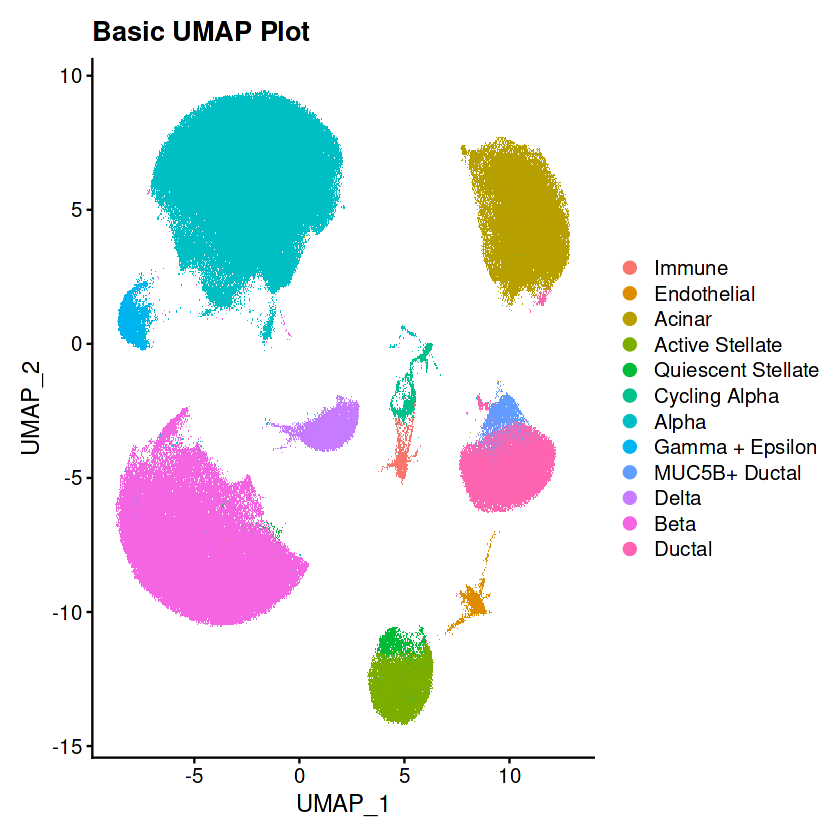

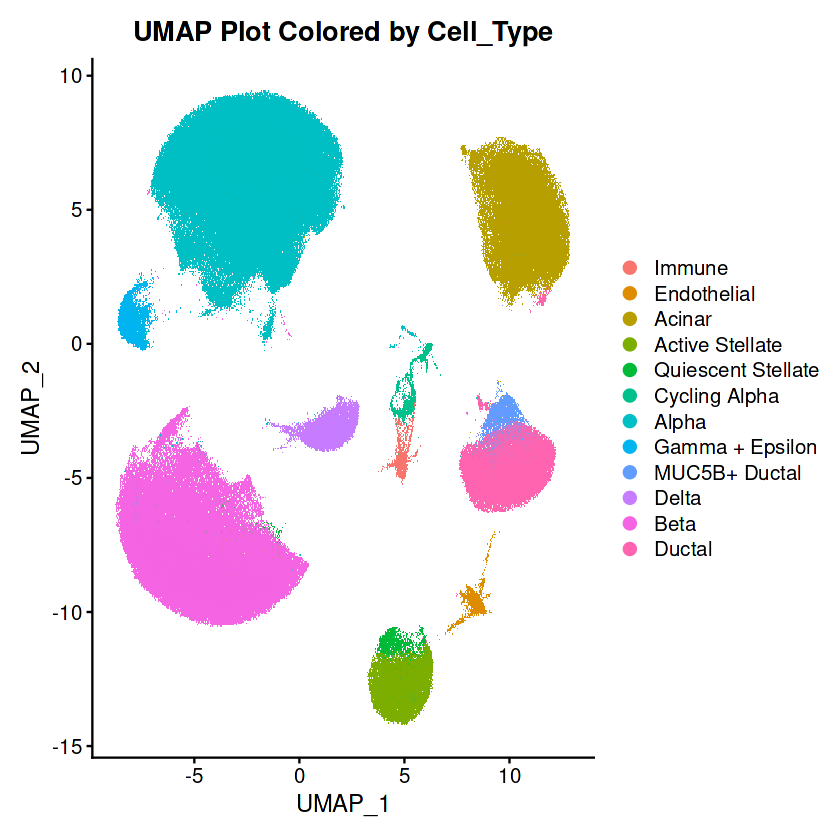

In [22]:
if (exists("seurat_obj") && !is.null(seurat_obj)) {
  
  # Check for UMAP or other reductions
  if ("umap" %in% names(seurat_obj@reductions)) {
    reduction_to_use <- "umap"
  } else if ("tsne" %in% names(seurat_obj@reductions)) {
    reduction_to_use <- "tsne"
    cat("UMAP not available, using t-SNE instead.\n")
  } else if (length(names(seurat_obj@reductions)) > 0) {
    reduction_to_use <- names(seurat_obj@reductions)[1]
    cat("Using first available reduction:", reduction_to_use, "\n")
  } else {
    cat("No dimensional reductions available in the object.\n")
    reduction_to_use <- NULL
  }
  
  if (!is.null(reduction_to_use)) {
    # Basic UMAP/reduction plot
    p_basic <- DimPlot(seurat_obj, reduction = reduction_to_use) +
      ggtitle(paste("Basic", toupper(reduction_to_use), "Plot"))
    print(p_basic)
    
    # Check for clustering information
    cluster_cols <- grep("cluster|seurat_clusters", colnames(seurat_obj@meta.data), 
                        value = TRUE, ignore.case = TRUE)
    
    if (length(cluster_cols) > 0) {
      cat("Found cluster information in:", cluster_cols[1], "\n")
      p_cluster <- DimPlot(seurat_obj, reduction = reduction_to_use, 
                          group.by = cluster_cols[1]) +
        ggtitle(paste(toupper(reduction_to_use), "Plot Colored by", cluster_cols[1]))
      print(p_cluster)
    }
    
    # Check for cell type annotations
    celltype_cols <- grep("cell.type|celltype|annotation", colnames(seurat_obj@meta.data), 
                         value = TRUE, ignore.case = TRUE)
    
    if (length(celltype_cols) > 0) {
      cat("Found cell type information in:", celltype_cols[1], "\n")
      p_celltype <- DimPlot(seurat_obj, reduction = reduction_to_use, 
                           group.by = celltype_cols[1]) +
        ggtitle(paste(toupper(reduction_to_use), "Plot Colored by", celltype_cols[1]))
      print(p_celltype)
    }
  }
  
} else {
  cat("Cannot create UMAP plot - Seurat object not available.\n")
}

## Your downstream analysis starts here!!

### **Comparative Analyses**
- **Differential expression** - Find marker genes and condition-specific changes
**Refer to PanKbase official pipeline**: https://github.com/PanKbase/PanKbase-DEG-analysis
- **Functional enrichment** - GO, KEGG, GSEA pathway analysis
- **Cell composition** - Compare proportions across samples/conditions

### **Advanced Analyses**
- **Trajectory analysis** - Pseudotime and developmental pathways (Monocle, Slingshot)
- **Cell communication** - Ligand-receptor interactions (CellChat) 
- **Gene regulation** - Transcription factor networks (SCENIC)
- **Integration** - Combine multiple datasets or modalities